<a href="https://colab.research.google.com/github/Megachell/Taxis/blob/main/Taxis_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After every taxi ride I receive an email containing various information about my ride, including car model, drivers' name and so on. The idea is to analyze these reports and extract some information like how many times have I had a ride with the same driver or on the same car.

In [1]:
!pip install ibm_db

     |████████████████████████████████| 798kB 4.2MB/s 
  Created wheel for ibm-db: filename=ibm_db-3.0.4-cp37-cp37m-linux_x86_64.whl size=40999786 sha256=c7902c28554a06758ed6061b018f844120b41292d771e2ae469fd6caaa9b944d
  Stored in directory: /root/.cache/pip/wheels/d9/85/7a/07dd5eba2f2d6a040be8aefb2b5051b0408c7f997259b5756b
Successfully built ibm-db


In [51]:
!pip install transliterate

     |████████████████████████████████| 51kB 2.5MB/s 


In [52]:
import mailbox
from IPython.core.display import HTML
import base64
import datetime
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import ibm_db
import ibm_db_dbi
from bs4 import BeautifulSoup
from transliterate import translit, get_available_language_codes

### Parse the mailbox

In [5]:
mbox = mailbox.mbox('/content/drive/MyDrive/Takeout/Inbox.mbox')

In [6]:
# Find letters from yandex taxi
archive = []
for i in range(0,len(mbox)):
  try:
    if mbox[i]['From'].split('@')[1] == "taxi.yandex.ru>":
      archive += [i]
  except:
    print('Error handeled in msg #{}'.format(i))

Error handeled in msg #613
Error handeled in msg #1104
Error handeled in msg #2940
Error handeled in msg #4116
Error handeled in msg #6697
Error handeled in msg #8586
Error handeled in msg #11786
Error handeled in msg #11851
Error handeled in msg #11994
Error handeled in msg #13235
Error handeled in msg #13835
Error handeled in msg #14170
Error handeled in msg #14307


In [21]:
# Function to convert dates from words to timestamp

def to_ts(dt,tm):
  month_num = {"января":1,"февраля":2,"марта":3,"апреля":4,"мая":5,"июня":6,"июля":7,"августа":8,"сентября":9,"октября":10,"ноября":11,"декабря":12}
  day,month,year = dt.split(' ')
  hour,minute = tm.split(':')
  ts = pd.Timestamp(year = int(year),month = month_num[month], day = int(day), hour = int(hour), minute = int(minute))
  return ts
  
# Extract the useful information from an email using regular expressions. 

def retrieve_data(plaintext_str):
  date = re.search(r'\d+\s\D+\s\d\d\d\d',plaintext_str).group(0)
  time = re.search(r'\d\d:\d\d',plaintext_str).group(0)
  timestamp = to_ts(date,time)

  price = re.search(r'\d+\s+руб',plaintext_str).group(0)
  price = int(re.search(r'\d+',price).group(0))

  tarif = re.search(r'Тариф:\s.+',plaintext_str).group(0)
  tarif = re.sub(r'Тариф:\s','',tarif)

  if tarif == 'Business':
    tarif = 'Бизнес'

  time_spent_str = re.search(r'Время\sв\sпути:\s.+',plaintext_str).group(0)
  time_spent_str = re.sub(r'Время\sв\sпути:\s','',time_spent_str)
  try:
    hours = re.search(r'\d+\s+ч',time_spent_str).group(0)
    hours = int(re.search(r'\d+',hours).group(0))
  except:
    hours = 0 
  try:
    minutes = re.search(r'\d+\s+мин',time_spent_str).group(0)
    minutes = int(re.search(r'\d+',minutes).group(0))
  except:
    minutes = 0
  try:
    seconds = re.search(r'\d+\s+сек',time_spent_str).group(0)
    seconds = int(re.search(r'\d+',seconds).group(0))
  except:
    seconds = 0
  time_spent = seconds+60*minutes+3600*hours

  try:
    driver = re.search(r'Водитель:\s\w+\s\w+\s\w+',plaintext_str).group(0)
    driver = re.sub(r'Водитель:\s','',driver)
  except:
    driver = re.search(r'Водитель:\s\w+\s\w+',plaintext_str).group(0)
    driver = re.sub(r'Водитель:\s','',driver)

  driver_name_only = driver.split(' ')[1]

  sub_str = re.findall(r'Автомобиль:\s.+',plaintext_str)[0].split(' ')
  color, car, car_model ,number = sub_str[1], sub_str[2],sub_str[3], sub_str[-1]

  if color == 'черный':
    color = 'чёрный'

  return {'DATE':timestamp,'PRICE': price, 'TARIF':tarif,'TIME_SPENT': time_spent,'DRIVER': driver, 'NAME': driver_name_only ,'COLOR':color,'CAR': car, 'CAR_MODEL': car_model, 'NUMBER':number}

# Some emails are table-based. 
# This kind of mails are not suitable for the previous function but the information can be extracted with HTML parser.
def retrieve_data_2(plaintext_str):
  soup = BeautifulSoup(plaintext_str, 'html.parser')

  timestamp = to_ts(soup.findAll("td",{'class':'report__value'})[5].getText()[:-3],'00:00')

  tarif = soup.findAll("td",{'class':'report__value'})[4].getText()

  if tarif == 'Business':
    tarif = 'Бизнес'

  color, car, car_model = soup.findAll("td",{'class':'report__value'})[3].getText().split('\n')[1].split(' ')

  if color == 'черный':
    color = 'чёрный'

  price = int(soup.findAll("td",{'class':'report__value'})[1].getText()[:-2])
  driver = soup.find("p",{'class':'details__value'}).getText()
  driver_name_only = driver.split(' ')[1]
  number = soup.find("p",{'class':'car-number'}).getText()
  time_spent_str = soup.find("p",{'class':'ride-time'}).getText()
  try:
    hours = re.search(r'\d+\s+ч',time_spent_str).group(0)
    hours = int(re.search(r'\d+',hours).group(0))
  except:
    hours = 0 
  try:
    minutes = re.search(r'\d+\s+мин',time_spent_str).group(0)
    minutes = int(re.search(r'\d+',minutes).group(0))
  except:
    minutes = 0
  try:
    seconds = re.search(r'\d+\s+сек',time_spent_str).group(0)
    seconds = int(re.search(r'\d+',seconds).group(0))
  except:
    seconds = 0
  time_spent = seconds+60*minutes+3600*hours

  return {'DATE':timestamp,'PRICE': price, 'TARIF':tarif,'TIME_SPENT': time_spent,'DRIVER': driver,'NAME': driver_name_only ,'COLOR':color, 'CAR': car, 'CAR_MODEL': car_model, 'NUMBER':number}

In [22]:
# Load info to the dataframe
df = pd.DataFrame(columns=('DATE', 'PRICE', 'TARIF', 'TIME_SPENT', 'DRIVER', 'NAME', 'COLOR', 'CAR', 'CAR_MODEL', 'NUMBER'))
t = 0
k = 0
exceptions = []
for i in archive:
  try:
    message = mbox[i]
    body = message.get_payload()[0]
    plaintext_bytes = base64.b64decode(max(str(body).split('\n\n'), key=len))
    plaintext_str = plaintext_bytes.decode('utf-8')
    try:
      df = df.append(retrieve_data(plaintext_str), ignore_index=True)
    except:
      df = df.append(retrieve_data_2(plaintext_str), ignore_index=True)
    k += 1
  except:
    exceptions += [i]
    t += 1
print("{} rides sucсessfully added, {} exceptions".format(k,t))

1346 rides sucсessfully added, 5 exceptions


In [9]:
df['NAME_HASH'] = 0
for i in df.index:
  df['NAME_HASH'].loc[i] = hash(df['DRIVER'].loc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Export data to the dataframe, so it will be easier to access it in the future/

In [ ]:
file = open("/content/drive/MyDrive/Colab Notebooks/creds.txt", 'r')
creds = file.read()
file.close()

In [ ]:
connection = ibm_db.connect(creds, '', '')
stmnt = "create table TAXIS(ID int primary key not null, Date varchar(60), Price int, Tarif varchar(60), Time_spent int, Driver varchar(100), Name varchar(100), Color varchar(60),Car varchar(60), Car_model varchar(60), Number varchar(60), NAME_HASH bigint)"
ibm_db.exec_immediate(connection, stmnt)
query = 'insert into TAXIS (ID, Date, Price, Tarif, Time_spent, Driver, Name, Color, Car, Car_model, Number, Name_Hash)\n values\n'
for i in df.index:
  query += "({},'{DATE}',{PRICE},'{TARIF}','{TIME_SPENT}','{DRIVER}','{NAME}','{COLOR}','{CAR}','{CAR_MODEL}','{NUMBER}','{NAME_HASH}'),\n".format(i,**df.loc[i])
query = query[:-2]
ibm_db.exec_immediate(connection, query.replace("Cee'd","Cee''d"))
ibm_db.close(connection)

True

### Lets have a look at the rides

Load date from the database. In the future it is reasonable to start from here, and not parse the emails all every time.

In [ ]:
file = open("/content/drive/MyDrive/Colab Notebooks/creds.txt", 'r')
creds = file.read()
file.close()
connection = ibm_db.connect(creds, '', '')
conn = ibm_db_dbi.Connection(connection)
df = pd.read_sql('select * from TAXIS',conn, index_col='ID')
ibm_db.close(connection)

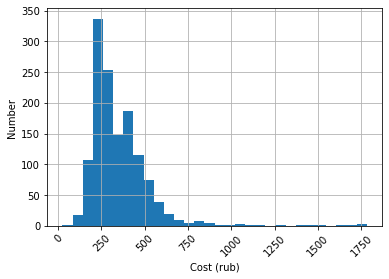

In [25]:
#@title Rides cost istogram
plt.hist(x=df['PRICE'], bins = 30)
plt.grid(which='major', axis='both')
plt.xticks(rotation=45)
plt.xlabel('Cost (rub)')
plt.ylabel('Number')
plt.show()

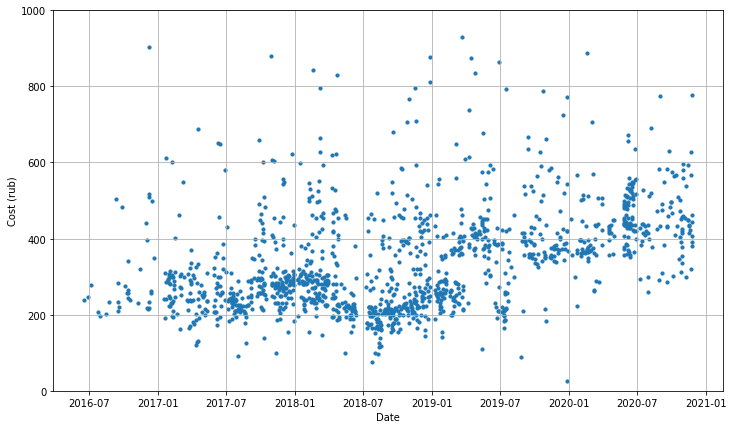

In [26]:
#@title Rides become more expensive with time
Row = df.sort_values(by=['DATE'])[['DATE','PRICE']]
plt.figure(figsize=(12,7))
plt.ylim(0,1000)
plt.scatter(Row['DATE'],Row['PRICE'], s=10)
plt.grid(which='major', axis='both')
plt.xlabel('Date')
plt.ylabel('Cost (rub)')
plt.show()

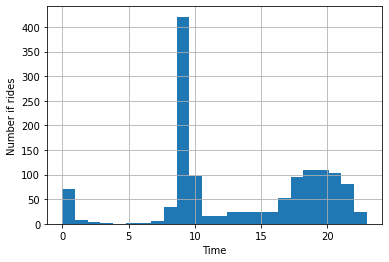

In [30]:
#@title I usually take taxi to ither get to work or return home. The narrow peak are rides to work, the wide one - return rides.
plt.hist(df['DATE'].apply(lambda x: x.hour), bins = 24)
plt.grid(which='major', axis='both')
plt.xlabel('Time')
plt.ylabel('Number if rides')
plt.show()

In [31]:
#@title It's almost round score
tt = df['TIME_SPENT'].sum()
days = tt//86400
tt -= days*88500
hours = tt//3600
tt-= hours*3600
minutes = tt//60
tt-= minutes*60 
print('I have spent {} days, {} hours, {} minutes, {} seconds in taxis'.format(days,hours,minutes,tt))

I have spent 16 days, 0 hours, 2 minutes, 44 seconds in taxis


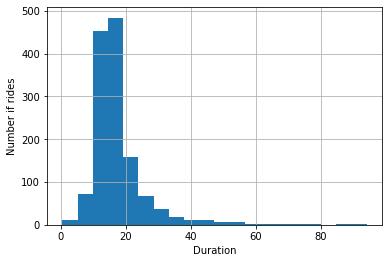

In [33]:
#@title The majority of the rides are shorter than 20 minutes
plt.hist(df['TIME_SPENT']/60, bins = 20)
plt.grid(which='major', axis='both')
plt.xlabel('Duration')
plt.ylabel('Number if rides')
plt.show()

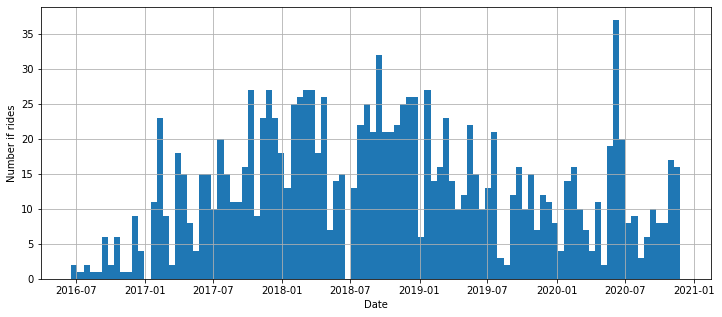

In [35]:
#@title This is how frequently i took taxi over the years. Pandemic made me set a new record.

plt.figure(figsize=(12,5))
plt.grid(which='major', axis='both')
plt.hist(df['DATE'], bins=100)
plt.xlabel('Date')
plt.ylabel('Number if rides')
plt.show()

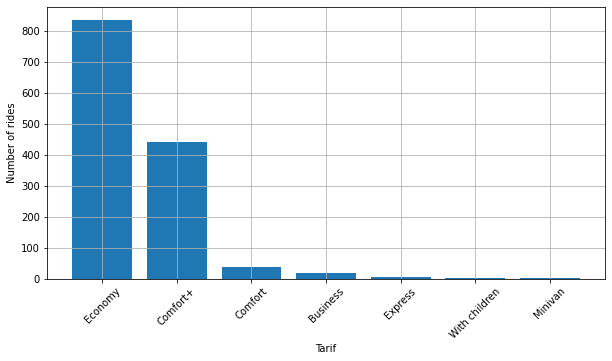

In [57]:
#@title The most popular tarifs
m = df['TARIF'].value_counts()
plt.figure(figsize=(10,5))
tarif_translate = {'Эконом': 'Economy', 'Комфорт+':'Comfort+', 'Комфорт':'Comfort', 'Бизнес':'Business', 'Экспресс':'Express', 'Детский':'With children', 'Минивэн':'Minivan'}
labels = [tarif_translate[i] for i in m.keys()]
plt.bar(x=labels, height = m.values)
plt.grid(which='major', axis='both')
plt.xticks(rotation=45)
plt.xlabel('Tarif')
plt.ylabel('Number of rides')
plt.show()

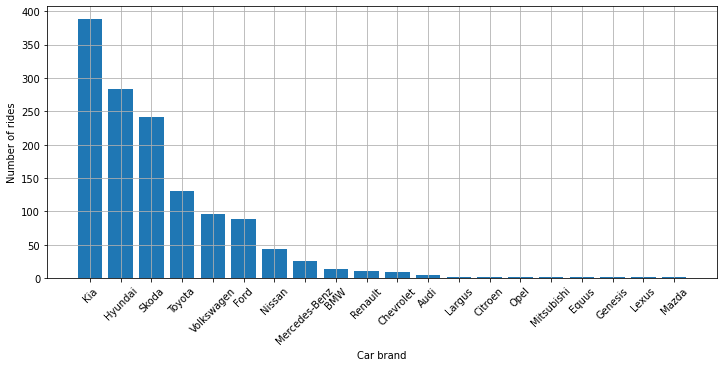

In [40]:
#@title The most popular cars
m = df['CAR'].value_counts()
plt.figure(figsize=(12,5))
plt.bar(x=m.keys(), height = m.values)
plt.grid(which='major', axis='both')
plt.xticks(rotation=45)
plt.xlabel('Car brand')
plt.ylabel('Number of rides')
plt.show()

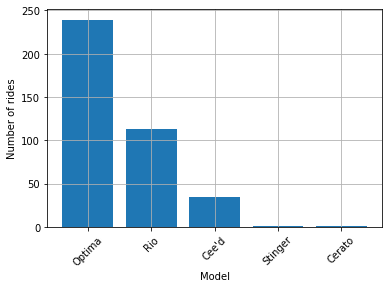

In [41]:
#@title The most poular kias
m = df[df['CAR'] == 'Kia']['CAR_MODEL'].value_counts()
plt.bar(x=m.keys(), height = m.values)
plt.grid(which='major', axis='both')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Number of rides')
plt.show()

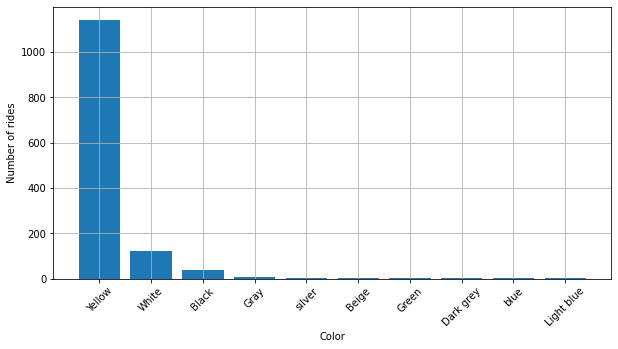

In [50]:
#@title The most popular colors
m = df['COLOR'].value_counts()
plt.figure(figsize=(10,5))
translate = {'жёлтый': 'Yellow', 'белый': 'White', 'чёрный': 'Black', 'желтый': 'Yellow', 'серый': 'Gray', 'серебристый':'silver',
       'бежевый':'Beige', 'зелёный':'Green', 'темно-серый':'Dark grey', 'синий':'blue', 'голубой':'Light blue'}
labels = [translate[i] for i in m.keys()]
plt.bar(x=labels, height = m.values)
plt.grid(which='major', axis='both')
plt.xticks(rotation=45)
plt.xlabel('Color')
plt.ylabel('Number of rides')
plt.show()

### Coinsidence? I think not!

How many time did I ride with the same driver?

In [54]:
df_drivers = pd.DataFrame(columns=('Year', 'Driver', 'Tarif', 'Delta_days', 'Same_car', 'Same_tarif'))
m = df['DRIVER'].value_counts()
for driver in m[m.values >= 2].keys():
  ind = df[df['DRIVER'] == driver].index
  tarif = df['TARIF'][ind[0]]
  year = pd.to_datetime(df['DATE'][ind[0]]).year
  time_left = abs((pd.to_datetime(df['DATE'][ind[0]]) - pd.to_datetime(df['DATE'][ind[1]])).days)
  same_car = df['NUMBER'][ind[0]] == df['NUMBER'][ind[1]]
  same_tarif = df['TARIF'][ind[0]] == df['TARIF'][ind[1]]
  df_drivers = df_drivers.append({'Year': year,
                                  'Driver': driver.split(' ')[1],
                                  'Tarif': tarif,
                                  'Delta_days': time_left,
                                  'Same_car':same_car,
                                  'Same_tarif': same_tarif},
                                  ignore_index=True)
df_drivers['Driver'] = df_drivers['Driver'].apply(lambda x: translit(x, 'ru', reversed=True))
df_drivers['Tarif'] = df_drivers['Tarif'].apply(lambda x: tarif_translate[x])

In [59]:
df_drivers

,Year,Driver,Tarif,Delta_days,Same_car,Same_tarif
0,2020,Mamuka,Comfort+,6,True,True
1,2020,Ivan,Comfort+,737,False,False
2,2017,Mamadali,Economy,297,False,True
3,2020,Igor',Comfort+,918,False,False
4,2020,Aleksandr,Comfort+,6,True,True
5,2017,Vadim,Economy,156,False,True
6,2018,Aleksandr,Economy,57,False,True
7,2019,Denis,Comfort+,524,True,True
8,2020,Sergej,Comfort+,11,True,True
9,2017,Sergej,Economy,326,False,True


Mamuka drove me 3 times, and I rode his car 4 times.

In [61]:
mamuka = df[df['NUMBER'] == 'МР37077'].drop(['DRIVER', 'TIME_SPENT','PRICE'], axis='columns')
mamuka['NAME'] = mamuka['NAME'].apply(lambda x: translit(x, 'ru', reversed=True))
mamuka['TARIF'] = mamuka['TARIF'].apply(lambda x: tarif_translate[x])
mamuka['COLOR'] = mamuka['COLOR'].apply(lambda x: translate[x])
mamuka

,DATE,TARIF,NAME,COLOR,CAR,CAR_MODEL,NUMBER
19,2020-06-23 10:36:00,Comfort+,Mamuka,Yellow,Toyota,Camry,МР37077
20,2020-06-17 09:08:00,Comfort+,Mamuka,Yellow,Toyota,Camry,МР37077
63,2020-06-05 08:00:00,Comfort+,Mamuka,Yellow,Toyota,Camry,МР37077
289,2019-11-27 09:46:00,Comfort+,David,Yellow,Toyota,Camry,МР37077


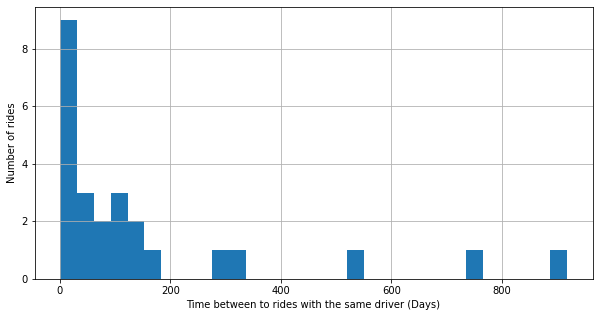

In [63]:
#@title Haw many days does usually pass between two rides with the same driver? After 200 days it is almost impossible to meet driver again. Seems like drivers do not work in taxi for long time.
plt.figure(figsize=(10,5))
plt.hist(df_drivers['Delta_days'], bins = 30)
plt.grid(which='major', axis='both')
plt.xlabel('Time between to rides with the same driver (Days)')
plt.ylabel('Number of rides')
plt.show()

In [64]:
#@title First I hade a ride with these guys in Economy class, after a few years I met them again in Comfort+
comfort_plus = df.loc[[925,151,902,138]].drop(['DRIVER', 'TIME_SPENT','PRICE'], axis='columns')

comfort_plus['NAME'] = comfort_plus['NAME'].apply(lambda x: translit(x, 'ru', reversed=True))
comfort_plus['TARIF'] = comfort_plus['TARIF'].apply(lambda x: tarif_translate[x])
comfort_plus['COLOR'] = comfort_plus['COLOR'].apply(lambda x: translate[x])
comfort_plus

,DATE,TARIF,NAME,COLOR,CAR,CAR_MODEL,NUMBER
925,2017-10-11 09:40:00,Economy,Igor',Yellow,Hyundai,i40,ВЕ20377
151,2020-04-16 12:38:00,Comfort+,Igor',Yellow,Toyota,Camry,МТ67877
902,2018-04-11 09:50:00,Economy,Ivan,Yellow,Kia,Rio,РС67077
138,2020-04-17 14:22:00,Comfort+,Ivan,Yellow,Kia,Optima,МН58777


How may time did I ride the same car?

In [65]:
df_cars = pd.DataFrame(columns=('Year', 'Delta_days', 'Same_driver', 'Car', 'Car_model', 'Number','Tarif'))
m = df['NUMBER'].value_counts()
for number in m[m.values == 2].keys():
  ind = df[df['NUMBER'] == number].index
  tarif = df['TARIF'][ind[1]]
  year = pd.to_datetime(df['DATE'][ind[0]]).year
  time_left = abs((pd.to_datetime(df['DATE'][ind[0]]) - pd.to_datetime(df['DATE'][ind[1]])).days)
  same_driver = df['DRIVER'][ind[0]] == df['DRIVER'][ind[1]]
  df_cars = df_cars.append({'Year':year, 
                            'Delta_days':time_left, 
                            'Same_driver':same_driver, 
                            'Car':df['CAR'][ind[0]], 
                            'Car_model':df['CAR_MODEL'][ind[0]], 
                            'Number':df['NUMBER'][ind[0]], 
                            'Tarif':tarif}, 
                           ignore_index=True)
df_cars['Tarif'] = df_cars['Tarif'].apply(lambda x: tarif_translate[x])

There are more reappearing cars than drivers. There seems to be fewer cars on roads than drivers. Some drivers seem to work on the same car.

In [66]:
df_cars

,Year,Delta_days,Same_driver,Car,Car_model,Number,Tarif
0,2017,37,True,Skoda,Rapid,ХХ05477,Economy
1,2017,63,False,Hyundai,i40,ВЕ20377,Economy
2,2019,524,True,Toyota,Camry,РР37677,Comfort+
3,2020,0,True,Kia,Optima,МР29477,Comfort+
4,2017,148,False,Kia,Rio,УВ10177,Economy
5,2019,201,False,Kia,Optima,НО04477,Comfort+
6,2020,16,True,Kia,Optima,ОХ94077,Comfort+
7,2017,72,False,Nissan,Almera,КО53277,Economy
8,2020,266,False,Hyundai,Sonata,ОА59477,Comfort+
9,2018,323,False,Hyundai,Solaris,АО20999,Economy


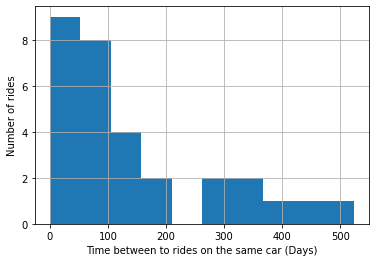

In [67]:
#@title After more than a year there still is a possibility to drive the same car.
plt.hist(df_cars['Delta_days'])
#plt.xlim((0,450))
plt.grid(which='major', axis='both')
plt.xlabel('Time between to rides on the same car (Days)')
plt.ylabel('Number of rides')
plt.show()

### Let's try to get some more data 

Two main points:

Let $p_c$ be the pobability to brake down in 1 day. Then probabillity to ride the same car on the day m after the first ride $P = \frac{1}{N}(1-p_c)^m$ After summation of the series one can get the probabllity of a ride on the same car at any day $\frac{1}{N * p_c} = \frac{29}{1346}$

Probability to ride the same car during time from day m to day m+n:

 $\frac{(1-p_c)^m}{N}*\frac{1-(1-p_c)^{m+n}}{p_c}$



Let's try to estimate the number of cars in Moscosw and duration of their operation cycle using these formulas.
The shape of a histogramm, representing times berween two rides on the same car allows us to estimate the duration of their use, and a number of double rides tells us the number of taxis in town.

In [68]:
count, division = np.histogram(list(df_cars['Delta_days']),bins=12, range=(0,600))
total_num = df.shape[0]
num_double = df_cars.shape[0]
count_prob = count/total_num

In [69]:
# Probability of second rite to occur between days x to х+50
def range_pos(x, prob):
  a = num_double/total_num
  p1 = (1-prob)
  b = a*(p1**50)
  return (a*(p1**x))-(b*(p1**(2*x)))

Let's try to pick such $p_c$ to make predicted histogram mach the real data. Keeping in mind, that I usually have a second ride in the middle of cars' operation cycle, we need to corrct the outcome correspondingly.

In [70]:
def loss(p,c):
  s = 0
  for i in range(0,len(c)):
    s += (range_pos(50*i,p)-c[i])**2
  return s

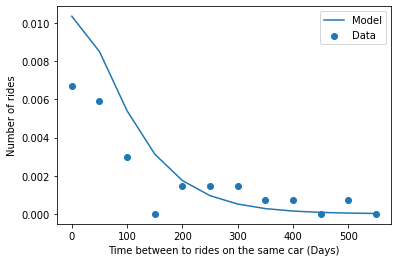

p =  0.006235969692695131


In [72]:
fun = lambda x : loss(x,count_prob)
res = minimize(fun,0.005)
P_b = 1-(1-res['x'][0])**0.5
Y = [range_pos(x*50,res['x'][0]) for x in range(0,12)]
X = [x*50 for x in range(0,12)]
plt.plot(X,Y, label = 'Model')
plt.scatter(X,count_prob, label = 'Data')
plt.xlabel('Time between to rides on the same car (Days)')
plt.ylabel('Number of rides')
plt.legend()
plt.show()
print('p = ', P_b)

In [73]:
N = total_num/(P_b*num_double)
t = np.log(1-(0.8))/np.log(1-P_b)
print('Number of cars in Moscow - {} \nOperation cycle - {} days'.format(int(N),int(t)))

Number of cars in Moscow - 7194 
Operation cycle - 257 days


In [75]:
count, division = np.histogram(list(df_drivers['Delta_days']),bins=18, range=(0,900))
total_num = df.shape[0]
num_double = df_drivers.shape[0]
count_prob = count/total_num

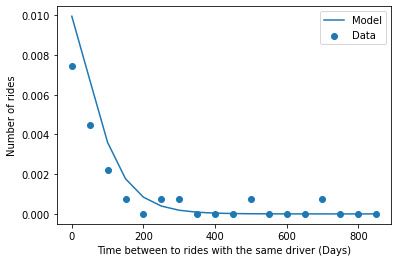

p =  0.007648373097994043


In [76]:
fun = lambda x : loss(x,count_prob)
res = minimize(fun,0.005)
P_b = 1-(1-res['x'][0])**0.5
Y = [range_pos(x*50,res['x'][0]) for x in range(0,18)]
X = [x*50 for x in range(0,18)]
plt.plot(X,Y, label = 'Model')
plt.scatter(X,count_prob, label = 'Data')
plt.xlabel('Time between to rides with the same driver (Days)')
plt.ylabel('Number of rides')
plt.legend()
plt.show()
print('p = ', P_b)

In [77]:
N = total_num/(P_b*num_double)
t = np.log(1-(0.8))/np.log(1-P_b)
print('Number of drivers in Moscow - {} \nOne driver on average works for - {} days'.format(int(N),int(t)))

Number of drivers in Moscow - 7039 
One driver on average works for - 209 days


As expected, there are fewer drivers than cars. But the difference is not that big.
Also, drivers retire sooner than cars.